In [1]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

In [3]:
train_dir = r'...\images_train'
val_dir = r'...\images_val'
test_dir = r'...\images_test'

In [4]:
# categories from json file
import json

# Open the JSON file
with open(r"...\plantnet300K_species_names.json") as f:
    data = json.load(f)

# Loop through the dictionary and print out each key-value pair
species = {}
for key, value in data.items():
    species[key] = value

In [5]:
train_datagen = image_dataset_from_directory(
  train_dir,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

test_datagen = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_datagen = image_dataset_from_directory(
    val_dir, 
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 243921 files belonging to 1081 classes.
Found 31112 files belonging to 1081 classes.
Found 31121 files belonging to 1081 classes.


In [6]:
def rename_classes(dataset):
    for i in range(len(dataset.class_names)):
        key = dataset.class_names[i]
        if key in species:
            dataset.class_names[i] = species[key]

In [7]:
rename_classes(train_datagen)
rename_classes(test_datagen)
rename_classes(val_datagen)

train_datagen.class_names[:1]

['Lactuca_virosa']

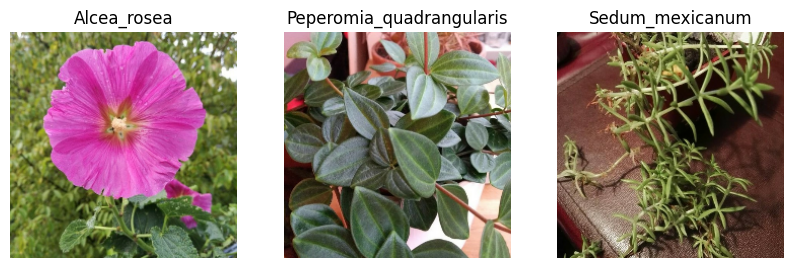

In [8]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_datagen.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_datagen.class_names[labels[i]])
    plt.axis("off")


In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_datagen = train_datagen.map(lambda x, y: (normalization_layer(x), y))
test_datagen = test_datagen.map(lambda x, y: (normalization_layer(x), y))
val_datagen = val_datagen.map(lambda x, y: (normalization_layer(x), y))

In [10]:
def EfficientNetB0(input_shape, num_classes):
  # Define the input layer
  inputs = tf.keras.layers.Input(shape=input_shape)

  # Define the stem convolutional layer
  x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('swish')(x)

  # Define the blocks of convolutional layers
  num_blocks = 5
  block_depths = [1, 2, 2, 3, 3]
  expansion_factors = [1, 6, 6, 6, 6]
  for i in range(num_blocks):
    # Define the block of convolutional layers
    for j in range(block_depths[i]):
      if j == 0:
        # First block in the sequence has a different number of filters and strides
        strides = 1 if i == 0 else 2
        x_shortcut = tf.keras.layers.Conv2D(16 * expansion_factors[i], kernel_size=1, strides=strides, padding='same')(x)
        x_shortcut = tf.keras.layers.BatchNormalization()(x_shortcut)
        x = tf.keras.layers.DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Conv2D(16 * expansion_factors[i], kernel_size=1, strides=1, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, x_shortcut])
      else:
        # All other blocks in the sequence have the same number of filters and strides
        x_shortcut = x
        x = tf.keras.layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Conv2D(16 * expansion_factors[i], kernel_size=1, strides=1, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, x_shortcut])

  # Define the top layers of the model
  x = tf.keras.layers.Conv2D(1280, kernel_size=1, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('swish')(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

  # Define the model and return it
  model = tf.keras.models.Model(inputs, x)
  return model

In [11]:
model = EfficientNetB0((224,224, 3), 1081)
with tf.device('gpu:0'):
    model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
history = model.fit(train_datagen, epochs=8, validation_data=val_datagen)

Epoch 1/8
7623/7623 [==============================] - 1219s 160ms/step - loss: 3.5622 - accuracy: 0.2750 - val_loss: 3.0254 - val_accuracy: 0.3606
Epoch 2/8
7623/7623 [==============================] - 1215s 159ms/step - loss: 2.6060 - accuracy: 0.4206 - val_loss: 2.4538 - val_accuracy: 0.4583
Epoch 3/8
7623/7623 [==============================] - 1215s 159ms/step - loss: 2.2151 - accuracy: 0.4887 - val_loss: 2.2197 - val_accuracy: 0.4996
Epoch 4/8
7623/7623 [==============================] - 1216s 159ms/step - loss: 1.9699 - accuracy: 0.5340 - val_loss: 2.1225 - val_accuracy: 0.5185
Epoch 5/8
7623/7623 [==============================] - 1219s 160ms/step - loss: 1.7957 - accuracy: 0.5655 - val_loss: 2.0718 - val_accuracy: 0.5295
Epoch 6/8
7623/7623 [==============================] - 1218s 160ms/step - loss: 1.6656 - accuracy: 0.5891 - val_loss: 1.9162 - val_accuracy: 0.5605
Epoch 7/8
7623/7623 [==============================] - 1217s 160ms/step - loss: 1.5576 - accuracy: 0.6101 - val_

In [18]:
model.evaluate(test_datagen)

973/973 [==============================] - 47s 48ms/step - loss: 1.9196 - accuracy: 0.5641


[1.9196298122406006, 0.5640588998794556]

In [ ]:
"SAVE MODEL"
import os
model.save(os.path.join('models', 'plant_species'))

In [ ]:
"LOAD MODEL"
import os
from tensorflow.keras.models import load_model
new_model = load_model(os.path.join('models', 'plant_species.h5'))

In [ ]:
"TESTING"
test_img = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

rename_classes(test_img)

1/1 [==============================] - 0s 21ms/step


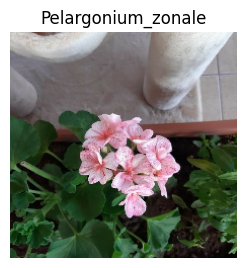

In [18]:
"TESTING"
import numpy as np
from matplotlib import pyplot as plt 

plt.figure(figsize=(10, 10))
for images, labels in test_img.take(1):
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(test_img.class_names[labels[i]])
    guess = new_model.predict(np.expand_dims(images[i]/255, 0))
    plt.axis("off")

In [19]:
"TESTING"
from queue import PriorityQueue
q = PriorityQueue(1081)

for i in range(len(guess[0])):
    q.put((guess[0][i]*(-1), i))

print("Confidence :  Species ")
print("___________________________\n")
for i in range(5):
    confidence, key = q.get()
    print(f'{round(confidence*-(100), 1)}%  : {list(species.values())[key]}  ')

Confidence :  Species 
___________________________

73.4%  : Pelargonium_zonale  
19.3%  : Pelargonium_zonale  
2.7%  : Pelargonium_inquinans  
1.5%  : Pelargonium_graveolens  
1.1%  : Pelargonium_x_hybridum  


In [ ]:
"EXTRA TRAINING"
new_history = new_model.fit(train_datagen, epochs=3, validation_data=val_datagen)

Epoch 1/3
 174/7623 [..............................] - ETA: 19:30 - loss: 1.1240 - accuracy: 0.7071

In [ ]:
new_model.evaluate(test_datagen)

In [14]:
"SAVE NEW_MODEL"
import os
new_model.save(os.path.join('models', 'plant_species.h5'))